# **Projekt II część semestru**
*Wykorzystane źródła:*
* https://stackoverflow.com/questions/66395494/how-to-reduce-the-noise-of-an-image-on-python
* https://docs.opencv.org/3.4/d5/d69/tutorial_py_non_local_means.html;
* https://docs.opencv.org/4.x/d8/d01/tutorial_discrete_fourier_transform.html;
* materiały z kursu I stopnia IB Metody numeryczne w optyce biomedycznej;
* https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.figure.html#matplotlib.pyplot.figure;
* https://www.image-engineering.de/library/image-quality/factors/1080-noise;
* https://www.kaggle.com/code/chanduanilkumar/adding-and-removing-image-noise-in-python;
* https://stackoverflow.com/questions/22937589/how-to-add-noise-gaussian-salt-and-pepper-etc-to-image-in-python-with-opencv;
* https://docs.opencv.org/4.x/da/d22/tutorial_py_canny.html;
* https://pyimagesearch.com/2015/03/23/sliding-windows-for-object-detection-with-python-and-opencv/;
* https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html;
* https://scikit-learn.org/stable/modules/model_evaluation.html;
* https://www.nature.com/articles/s41598-018-24577-8

### **Importowanie pakietów**
```
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
```
### **Wczytanie obrazu oraz przedstawienie kilku algorytmów odszumiania**
```
image = cv2.imread('DR1.jpeg', cv2.IMREAD_GRAYSCALE)

#filtr medianowy
def median_filter(a, n):
    im = np.zeros((n, n) + (a.shape[0] - n + 1, a.shape[1] - n + 1) + a.shape[2:], dtype = a.dtype)
    for i in range(n):
        for j in range(n):
            im[i, j] = a[i:i + im.shape[2], j:j + im.shape[3]]
    im = np.moveaxis(im, (0, 1), (-2, -1)).reshape(*im.shape[2:], -1)
    im = np.median(im, axis = -1)
    if im.dtype != a.dtype:
        im = (im.astype(np.float64) + 10 ** -7).astype(a.dtype)
    return im

median_reduced = median_filter(image, 2)

#filtr wykorzystujący wartosci srednie pikseli obrazu (ang. mean filter)
mean_reduced = cv2.fastNlMeansDenoising(image, None, 10, 10)

#filtr wykorzystujacy transformatę Fouriera
def fourier_filter(a):
    fft = cv2.dft(np.float32(image), flags=cv2.DFT_COMPLEX_OUTPUT)
    fft_shift = np.fft.fftshift(fft)
    r, c = image.shape
    cent_r, cent_c = r//2, c//2
    filtr = np.ones((r, c, 2), np.uint8)
    mask_radius = 10
    mask_center = [cent_r, cent_c]
    x, y = np.ogrid[:r, :c]
    mask_area = (x - mask_center[0])**2 + (y - mask_center[1])**2 <= mask_radius*mask_radius
    filtr[mask_area] = 0
    fshift = fft_shift * filtr
    f_ishift = np.fft.ifftshift(fshift)
    fft_reduced = cv2.idft(f_ishift)
    fft_reduced = cv2.magnitude(fft_reduced[:, :, 0], fft_reduced[:, :, 1])

    return fft_reduced

fft_reduced = fourier_filter(image)
```
### **Porównanie ze sobą obrazu wejściowego i obrazów z nałożonymi filtrami**
```
figure1 = plt.figure(dpi=300)
figure1.add_subplot(2, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Obraz OCT')
plt.axis('off')

figure1.add_subplot(2, 2, 2)
plt.imshow(median_reduced, cmap="gray")
plt.title("Filtr medianowy")
plt.axis('off')

figure1.add_subplot(2, 2, 3)
plt.imshow(mean_reduced, cmap="gray")
plt.title("Filtr usredniajacy")
plt.axis('off')

figure1.add_subplot(2, 2, 4)
plt.imshow(fft_reduced, cmap="gray")
plt.title("Filtr FFT")
plt.axis('off')
```
---
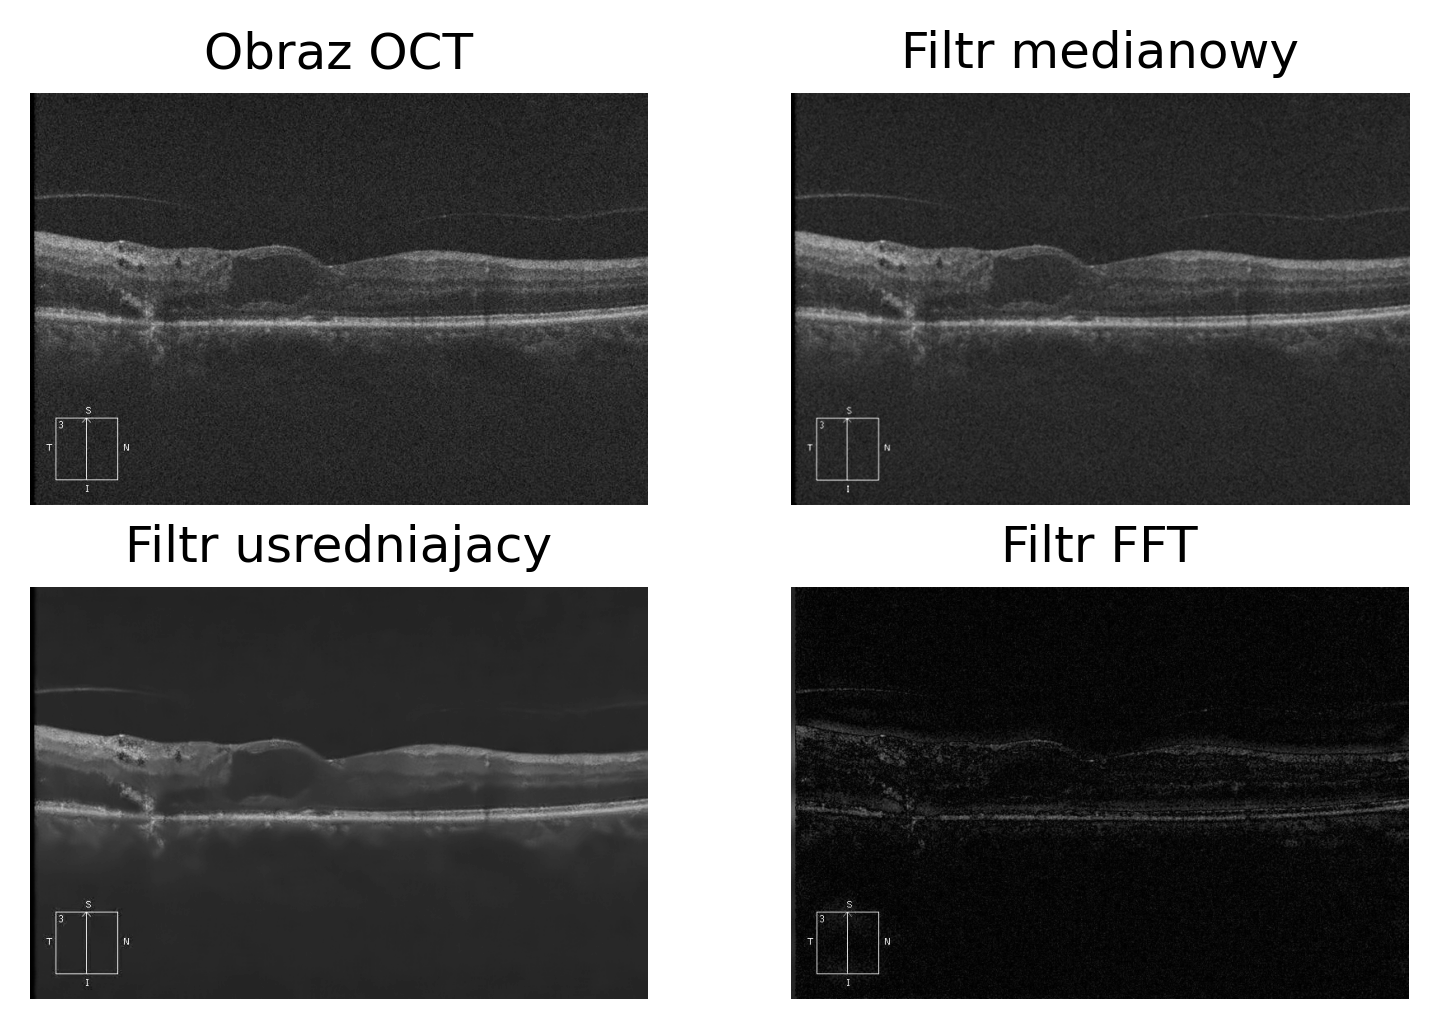
---

### **Rodzaje szumów oraz ich implementacja**
```
#szum Gaussowski
gauss_noise = np.zeros(image.shape,dtype=np.uint8)
cv2.randn(gauss_noise,128,20)
gauss_noise = (gauss_noise*0.5).astype(np.uint8)

gauss_noise_img = cv2.add(image, gauss_noise)

#szum salt and pepper
r, c = image.shape
sandp = 0.5 
sandp_image = image.copy()
#dodanie soli
salt = np.ceil(sandp * r * c)
coords = [np.random.randint(0, i - 1, int(salt)) for i in image.shape]
sandp_image[coords[0], coords[1]] = 255
#dodanie pieprzu
pepper = np.ceil(sandp * r * c)
coords = [np.random.randint(0, i - 1, int(pepper)) for i in image.shape]
sandp_image[coords[0], coords[1]] = 255


#szum uniform
uni_noise = np.zeros(image.shape,dtype=np.uint8)
cv2.randu(uni_noise,0,255)
uni_noise = (uni_noise*0.5).astype(np.uint8)
uniform_image = cv2.add(image, uni_noise)

#szum periodyczny
r, c = image.shape
amp = 20
freq = 10
x = np.arange(c)
y = np.arange(r)
X, Y = np.meshgrid(x, y)
line = amp * ((X % (c // freq)) < (c // (2 * freq)))
periodic_image = cv2.add(image, line.astype(np.uint8))
```
### **Wizualizacja wpływu szumów na obraz**
```
figure2 = plt.figure(dpi=300)
figure2.add_subplot(2, 2, 1)
plt.imshow(gauss_noise_img, cmap='gray')
plt.title('Szum Gaussowski')
plt.axis('off')

figure2.add_subplot(2, 2, 2)
plt.imshow(sandp_image, cmap='gray')
plt.title('Szum salt and pepper')
plt.axis('off')

figure2.add_subplot(2, 2, 3)
plt.imshow(uniform_image, cmap='gray')
plt.title('Szum typu uniform')
plt.axis('off')

figure2.add_subplot(2, 2, 4)
plt.imshow(periodic_image, cmap='gray')
plt.title('Szum periodyczny')
plt.axis('off')
```
---
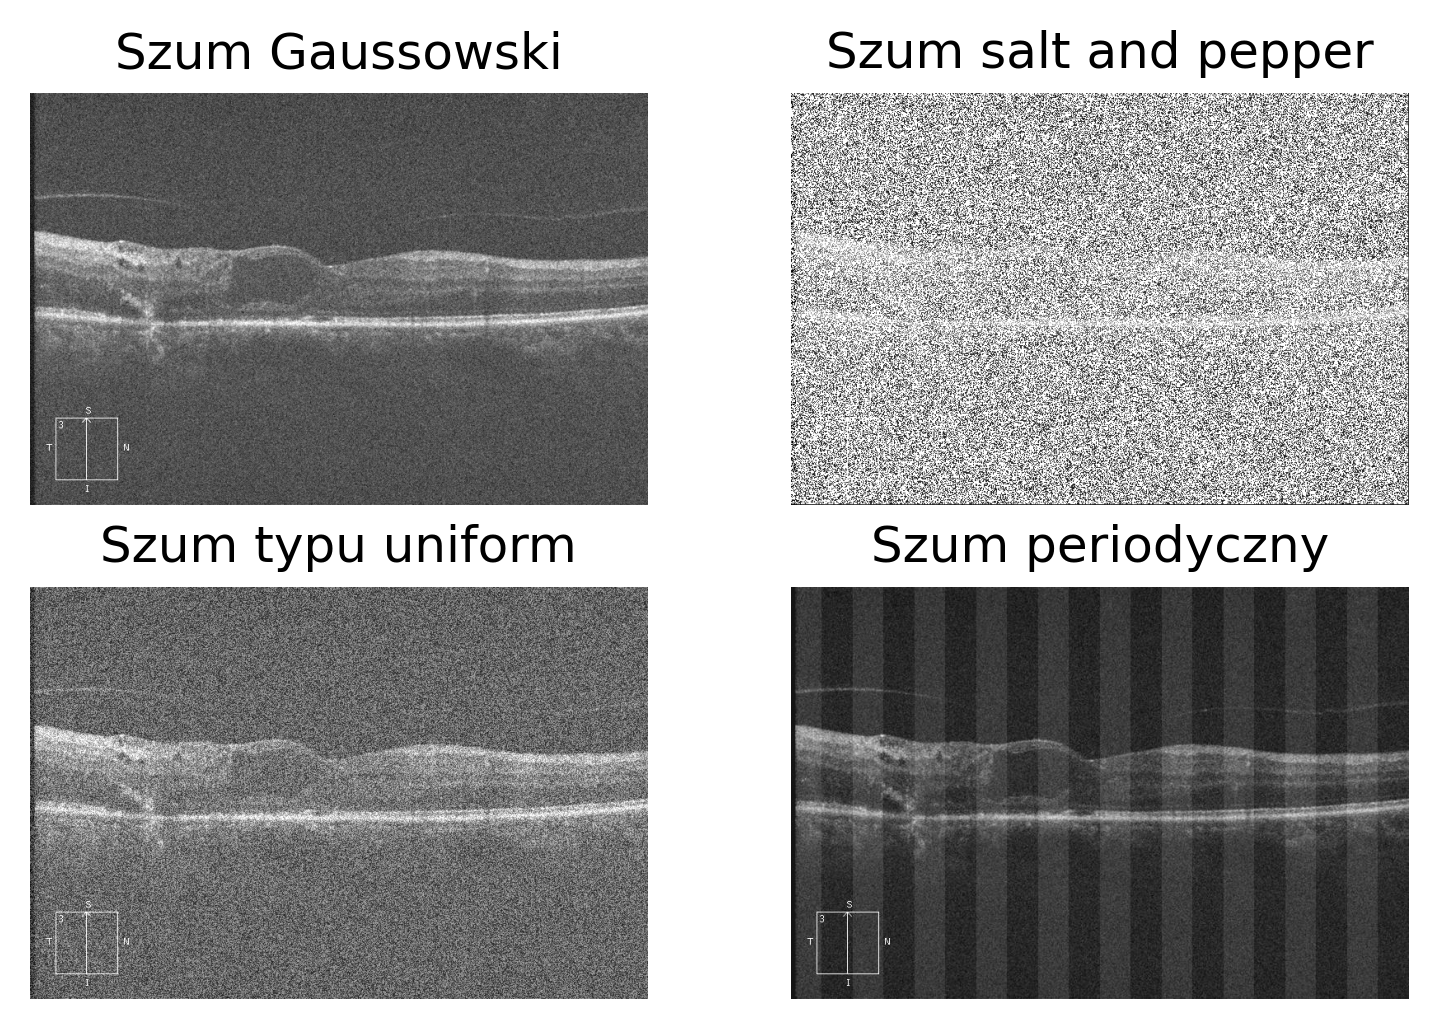
---
### **Algorytmy segmentacji obrazów**
```
#segmentacja metoda przesuwajacego sie okna (algorytm K-Mean)
def extract_features(image, window_size):
    #Wyodrebnianie cech dla danego obrazu za pomoca przesuwajacego sie okna o podanych wymiarach
    r, c = image.shape
    features = []
    positions =[]
    for i in range(window_size//2, r - window_size//2):
        for j in range (window_size//2, c - window_size//2):
            window = image[i-window_size//2:i+window_size//2 + 1, j-window_size//2:j+window_size//2 + 1]
            features.append(window.flatten())
            positions.append((i, j))
#zwracane sa wartosci zwiazane z odnaleznionymi elementami
    return np.array(features), positions

np.random.seed(50)
rows, cols = image.shape
X = np.random.rand(1000, 9*9)  # 1000 próbek, okno 9x9 px
y = np.random.randint(0, 2, 1000)  # Losowe etykiety 0 lub 1

#grupowanie elementow reprezentujacych szukany obiekt na obrazie 
window_size = 9
features, positions = extract_features(image, window_size)
num_clusters = 2
kmeans = KMeans(n_clusters=num_clusters, random_state=50)
kmeans.fit(features)
predictions = kmeans.predict(features)

segmented_image = np.zeros_like(image)
for (i, j), prediction in zip(positions, predictions):
        if prediction == 1:  #1 oznacza naczynie lub zarejestrowany element
            segmented_image[i, j] = 255

#Segmentacja metodą detekcji krawędzi
edges = cv2.Canny(image, 150, 150)

#Segmentacja przy wykorzystaniu binaryzacji
binary_image = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 19, 17)
```
### **Wizualizacja wykorzystanych algorytmów segmentacji**
```
figure3 = plt.figure(dpi=300)
figure3.add_subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Oryginalny obraz OCT')
plt.axis('off')
figure3.add_subplot(1, 2, 2)
plt.imshow(segmented_image, cmap='gray')
plt.title('Zsegmentowany obraz OCT')
plt.axis('off')
```
---
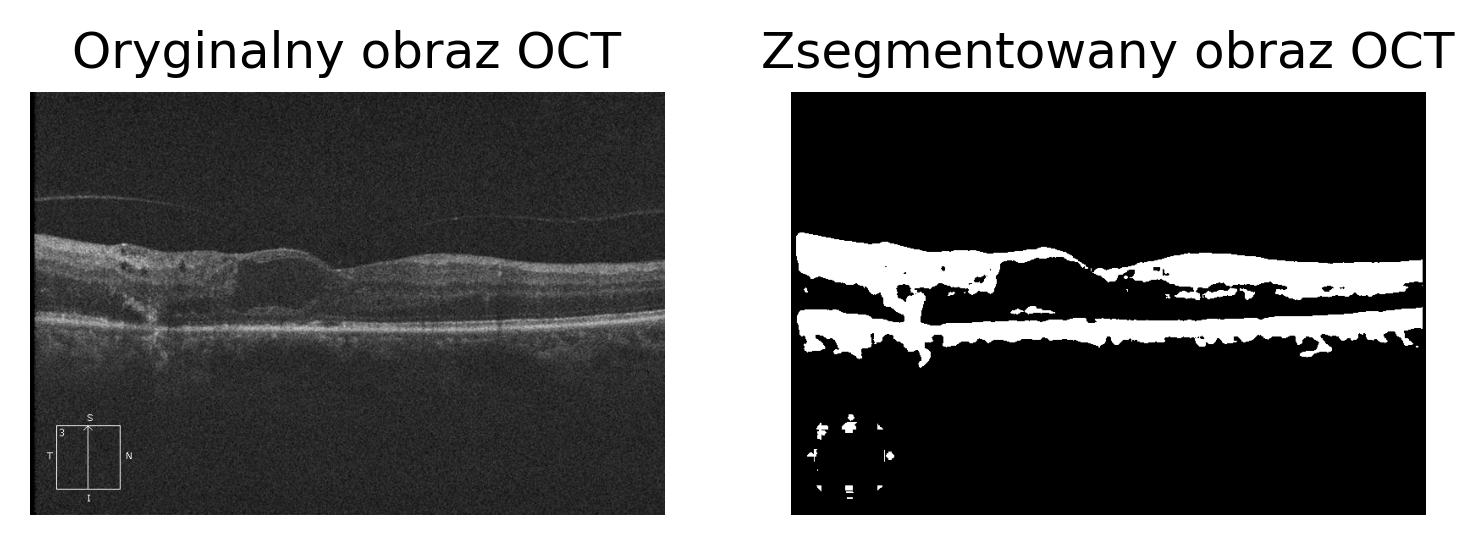
---
```
figure4 = plt.figure(dpi=300)
figure4.add_subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Oryginalny obraz OCT')
plt.axis('off')
figure4.add_subplot(1, 2, 2)
plt.imshow(edges, cmap='gray')
plt.title('Zsegmentowany obraz OCT')
plt.axis('off')
```
---
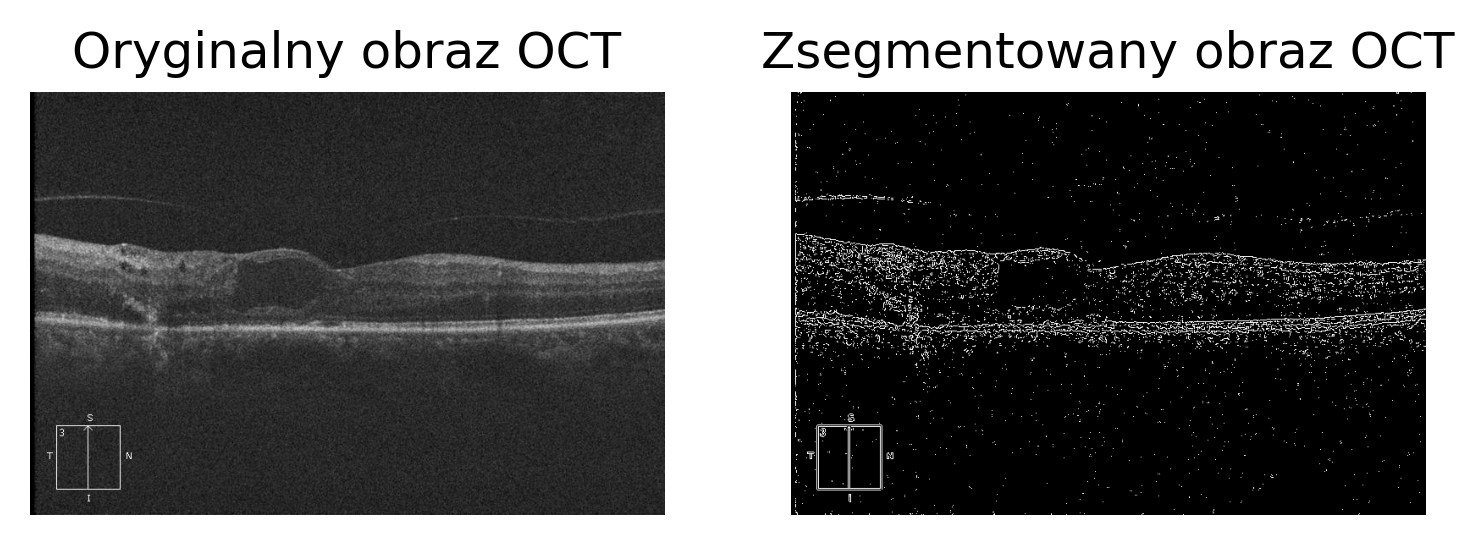
---
```
figure5 = plt.figure(dpi=300)
figure5.add_subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Oryginalny obraz OCT')
plt.axis('off')
figure5.add_subplot(1, 2, 2)
plt.imshow(binary_image, cmap='gray')
plt.title('Zsegmentowany obraz OCT')
plt.axis('off')
```
---
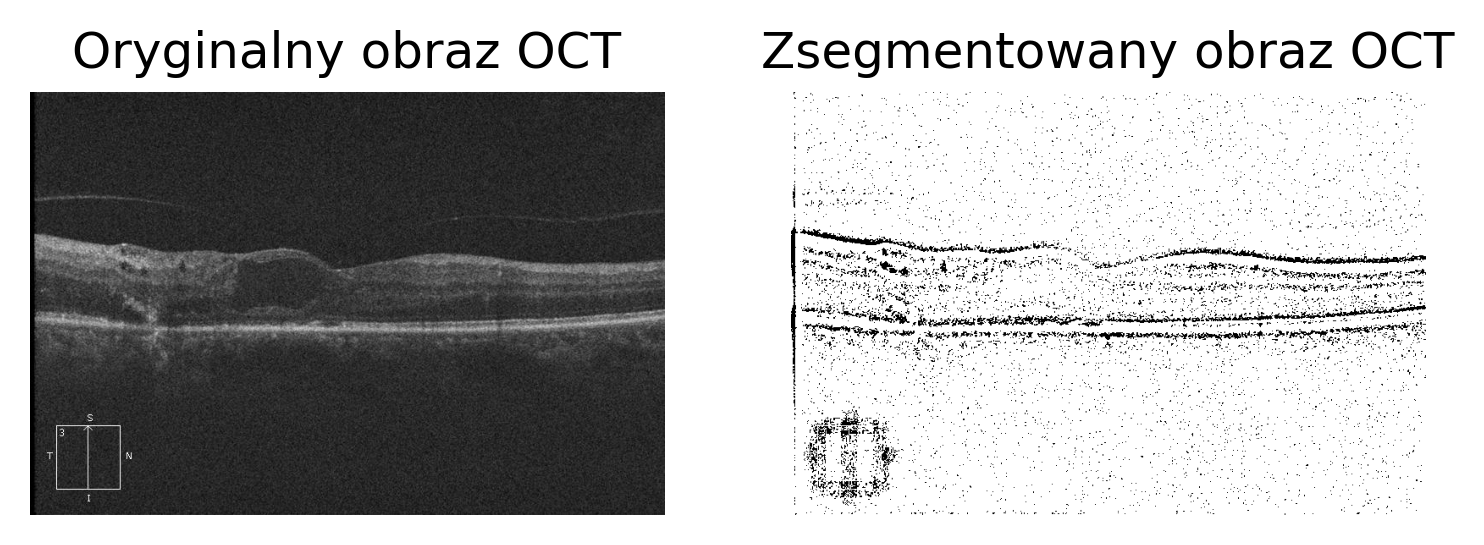
---
### **Ocena ilościowa metod segmentacji na podstawie ich dokładności i podobieństwa do obrazu początkowego**
```
def eval_segmentation(segmented_image, image):
    accuracy = accuracy_score(image.flatten(), segmented_image.flatten())
    return accuracy

before = cv2.imread('obrazprzed.jpg', cv2.IMREAD_GRAYSCALE)
after = cv2.imread('obrazpo.jpg', cv2.IMREAD_GRAYSCALE)

features, positions = extract_features(before, window_size)
num_clusters = 2
kmeans = KMeans(n_clusters=num_clusters, random_state=50)
kmeans.fit(features)
predictions = kmeans.predict(features)

segm_image = np.zeros_like(before)
for (i, j), prediction in zip(positions, predictions):
        if prediction == 1:  
            segm_image[i, j] = 255

edges_image = cv2.Canny(before, 150, 150) 

binar = cv2.adaptiveThreshold(before, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 19, 17)

window_eval = eval_segmentation(segm_image, after)
edge_eval = eval_segmentation(edges_image, after)
binar_eval = eval_segmentation(binar, after)

print('Analiza ilosciowa wykorzystanych metod segmentacji:')
print(f'Metoda przesuwajacego okna - Dokladnosc: {window_eval}')
print(f'Detekcja krawędzi - Dokladnosc: {edge_eval}')
print(f'Binaryzacja - Dokladnosc: {binar_eval}')
```
---
#### Obrazy przed i po segmentacji, do których były porównywane algorytmy
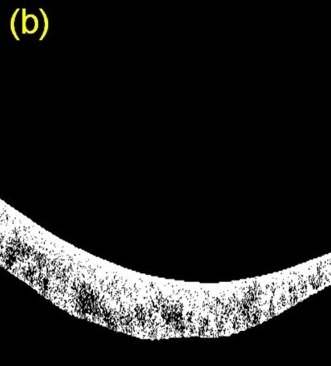 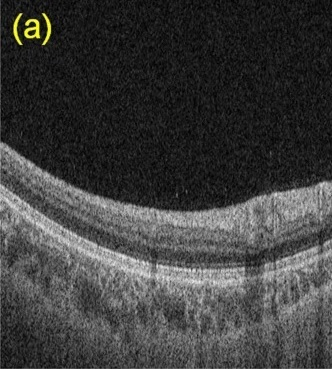
---
